<figure>
<IMG SRC="../../lectures/images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Assignment 8

### **Q1** Sampling theorem and aliasing

<div style='background:#F0F0F0'>**1** Create a band-limited white noise timeseries with $N=1000$ entries, $dt=0.1 s$, but with all frequencies greater than 0.5 Hz filtered.  Plot the power spectrum to make sure you got it correctly...
</div>

In [1]:
import numpy.random as random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.signal as signal
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
# Create white noise timeseries
def createWhiteNoise(dt,N):
    t = np.arange(0,N,dt)
    x = np.random.randn(N/dt)
    
    return t,x

# Apply filter
def applyFilter(B,dt,x):
    fp=B*0.7
    fs = B*0.9
    fNyq=1/2./dt
    n,fn=signal.ellipord(fp/fNyq, fs/fNyq,.1, 100.)
    b,a=signal.ellip(n,.1,100.,fn)
    x_limited = signal.filtfilt(b,a,x)
    
    return x_limited

# Plot the time series
def plotTimeSeries(t,x,x_limited):
    plt.figure(figsize=(12,6))
    gs=gridspec.GridSpec(1,1)
    
    ax=plt.subplot(gs[0:1])
    ax.plot(t,x,label='full-spectrum signal')
    ax.plot(t,x_limited,label='band-limited signal',linewidth=3,color='lightgreen')
    ax.set_xlabel('t [s]')
    ax.set_ylabel('x [V]')
    ax.set_title('Time Series')
    ax.legend(loc=3)
    ax.set_xlim(left=0,right=100)
    
    return ax

# Plot the power spectrum
def plotPowerSpectrum(t,x,x_limited,dt,nfft,B):
    # Compute spectra
    args = {'NFFT':nfft,'Fs':1./dt,'noverlap':nfft/2.,'window':mlab.window_hanning}
    Gxx,f = mlab.csd(x,x,**args)
    Gll,f = mlab.csd(x_limited,x_limited,**args)
    
    # Only plot absolute values
    Gxx = np.abs(Gxx)
    Gll = np.abs(Gll)
    
    plt.figure(figsize=(12,6))
    gs=gridspec.GridSpec(1,1)
    
    ax=plt.subplot(gs[0:1])
    ax.plot(f,Gxx,label='full-spectrum signal')
    ax.plot(f,Gll,label='band-limited signal')
    #ax.plot((B,B),(10e-13,1),color='red',linestyle='--',)
    ax.axvline(x=B,linestyle='--',color='red');ax.text(B,10e-4,' B=%0.1f Hz' %B,color='red')  # mark the B frequency
    ax.set_xlabel('f [Hz]')
    ax.set_ylabel(r'$G_{xx} \mathrm{[V^2 Hz^{-1}]}$')
    ax.set_title('Power Spectrum')
    ax.legend(loc=3)
    ax.loglog()
    ax.set_ylim(bottom=10e-8)
    
    return ax



Note the time series runs from t=0 to t=1000 but is only plotted to t=100 for clarity.


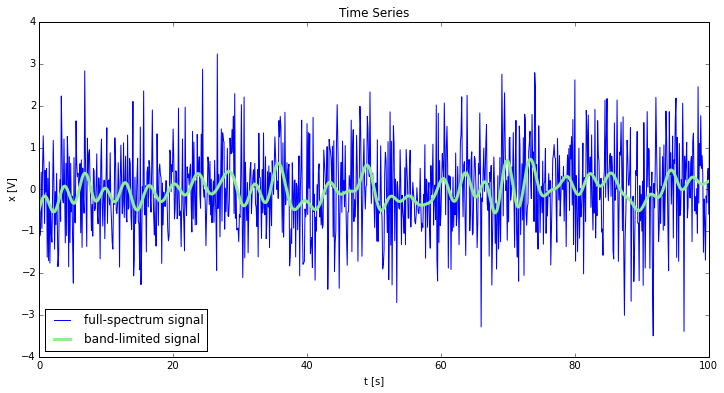

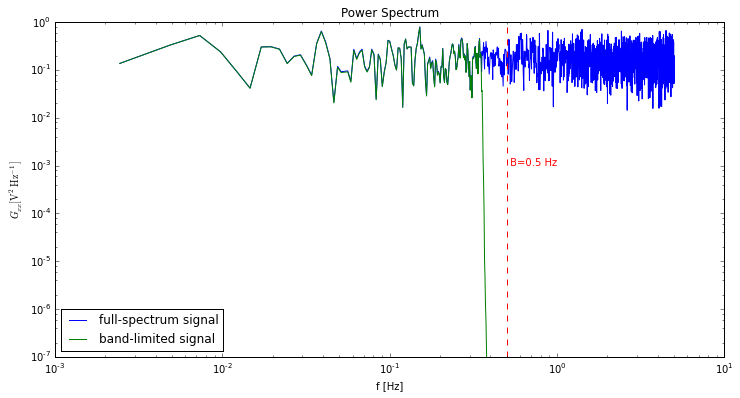

In [3]:
# Define the constants
dt = 0.1 #s
N = 1000 #entries
B = 0.5 #Hz
nfft = 2**12

# Run the functions
t,x = createWhiteNoise(dt,N)
x_limited = applyFilter(B,dt,x)

ax1 = plotTimeSeries(t,x,x_limited)
ax2 = plotPowerSpectrum(t,x,x_limited,dt,nfft,B)

print 'Note the time series runs from t=0 to t=1000 but is only plotted to t=100 for clarity.'

From the power spectrum we can see that the data has been filtered correctly, as all frequencies after B=0.5Hz go to zero. 

<div style='background:#F0F0F0'>**2** Now decimate by a factor of 4 to get a time series sampled at 2.5 Hz.  Show that you can recover the 10 Hz time series using the Sampling Theorem.</div>

In [4]:
# Decimate the time series and then recover it
def decimate(t,x,B,dec):
    x_decimated = x[::dec]
    t_decimated = t[::dec]
    
    N_dec = len(x_decimated)
    n = np.arange(N_dec)
    
    #B2 = (1.*B)/(1.*dec)
    B2 = B
    
    # reconstruct the full time series just from the subsampled data 
    
    xreco=1.*x[:N_dec*dec] # trim the last N*dec data points
    for i in range(N_dec*dec-1):
        xreco[i] = np.sum(x_decimated[:N_dec]*np.sinc(B2*t[i]-n))
        
    treco = t
    
    return t_decimated,x_decimated,treco,xreco
    
# plot time series
def plotDecimatedTimeSeries(t,x,t_dec,x_dec,treco,xreco):
    plt.figure(figsize=(12,6))
    gs=gridspec.GridSpec(1,1)
    
    ax=plt.subplot(gs[0:1])
    ax.plot(t,x,label='band-limited signal',linewidth=2)
    ax.plot(t_dec,x_dec,'o',label='decimated band-limited signal',markersize=5,color='lightgreen')
    ax.plot(treco,xreco,'--',label='recovered band-limited signal',linewidth=2,color='orange')
    ax.set_xlabel('t [s]')
    ax.set_ylabel('x [V]')
    ax.set_title('Time Series')
    ax.legend(loc=3)
    ax.set_xlim(left=0,right=100)
    
    return ax

# plot power spectrum
def plotDecimatedPowerSpectrum(x,x_lim,xreco,dt,nfft,F):
    # Compute spectra
    args = {'NFFT':nfft,'Fs':1./dt,'noverlap':nfft/2.,'window':mlab.window_hanning}
    Gxx,f = mlab.csd(x,x,**args)
    Gll,f = mlab.csd(x_lim,x_lim,**args)
    Grr,f = mlab.csd(xreco,xreco,**args)
    
    # Only plot absolute values
    Gxx = np.abs(Gxx)
    Gll = np.abs(Gll)
    Grr = np.abs(Grr)
    
    plt.figure(figsize=(12,6))
    gs=gridspec.GridSpec(1,1)
    
    ax=plt.subplot(gs[0:1])
    ax.plot(f,Gxx,label='signal',color='k')
    ax.plot(f,Gll,label='band-limited signal',color='blue')
    ax.plot(f,Grr,label='recovered band-limited signal',linestyle='--',color='orange')
    #ax.axvline(x=F,linestyle='--',color='k');ax.text(F,10e-4,' %0.1f Hz' %F,color='k')  # mark the singal frequency
    ax.set_xlabel('f [Hz]')
    ax.set_ylabel(r'$G_{xx} \mathrm{[V^2 Hz^{-1}]}$')
    ax.set_title('Power Spectrum')
    ax.legend(loc=3)
    ax.loglog()
    #ax.set_ylim(bottom=10e-8)
    
    return ax

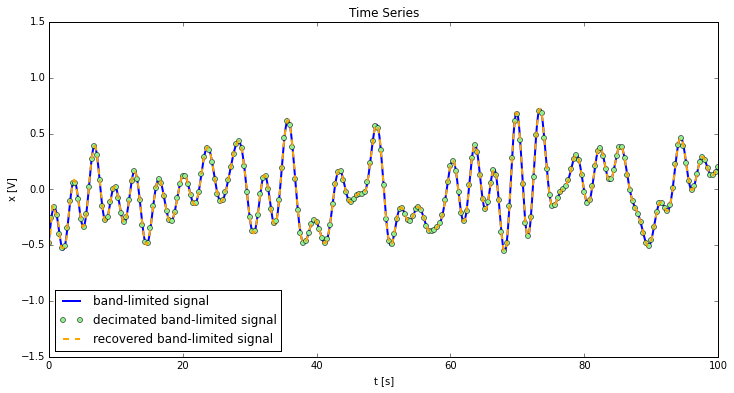

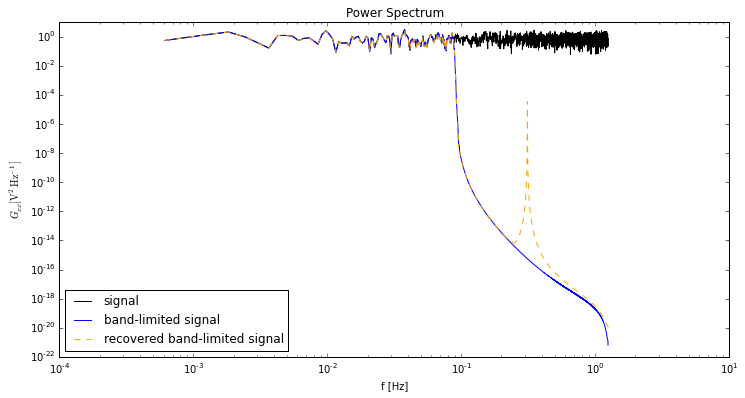

In [5]:
# Define the parameters
dec = 4
B_new = 2.5
dt_new = dt*dec
nfft_new = nfft

# Run the functions
t_dec,x_dec,treco,xreco = decimate(t,x_limited,B_new,dec)
ax1 = plotDecimatedTimeSeries(t,x_limited,t_dec,x_dec,treco,xreco)
ax2 = plotDecimatedPowerSpectrum(x,x_limited,xreco,dt_new,nfft_new,B_new)

The original 10Hz time series was indeed recovered through this method. This is proven in the above Time Series plot where the recovered band-limited signal aligns with the original band-limited signal.

<div style='background:#F0F0F0'>**3** Now decimate by a factor of 40 to get a time series sampled at 0.25 Hz.  Show that you cannot recover the 10 Hz time series using the Sampling Theorem.</div>

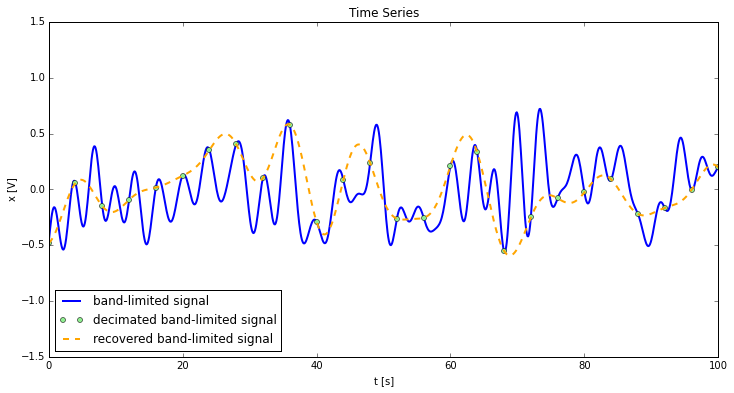

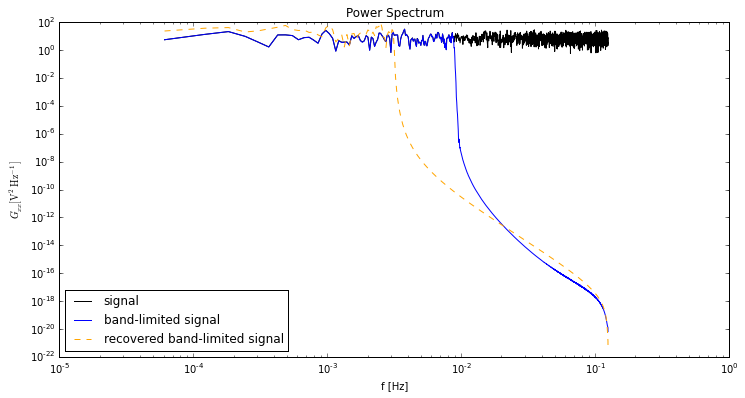

In [6]:
# Define the parameters
dec = 40
B_new = 0.25
dt_new = dt*dec
nfft_new = nfft

# Run the functions
t_dec2,x_dec2,treco2,xreco2 = decimate(t,x_limited,B_new,dec)
ax1 = plotDecimatedTimeSeries(t,x_limited,t_dec2,x_dec2,treco2,xreco2)
ax2 = plotDecimatedPowerSpectrum(x,x_limited,xreco2,dt_new,nfft_new,0.1)

Trying to reconstruct the 10Hz time series after decimating by a factor of 40 did not work. As can be seen in the Time Series plot above, the recovered band-limited signal is quite different to the original band-limited signal. This shows that we did not retain enough data whilst decimating the time series in order to reconstruct it afterwards. A smaller factor of decimation (keeping more data) produces a better reconstruction. 

## Q2: Cubic Spline

Using the data below...

In [7]:
t = np.array([0.,2.5,2.7,3.4,4.2,6.5,9.0])
x= np.cos(t*2*np.pi/3)


**1** Perform a cubic spline interpolation onto an even grid from 0 to 9.0 by 
  
  1. creating the matrix from the notes
  2. inverting and solving for the cubic co-efficients
  3. using those polynomials to evaluate the interpolated data.

Compare with using `scipy.interpolate.interp1d`.
Comment on any similarities or differences between the two results.

In [8]:
# Create the matrix
def createMatrix(t,x):
    N = len(t) - 1
    matrix = np.zeros((N+1,N+1))
    result = np.zeros(N+1)
    
    deltaT = np.diff(t)
    deltaX = np.diff(x)
    
    # fill in the matrix values
    matrix[0][0] = 1.
    matrix[N][N] = 1.
    
    for i in range(1,N):
        matrix[i][i-1] = deltaT[i-1]
        matrix[i][i] = 2.*(deltaT[i-1]+deltaT[i])
        matrix[i][i+1] = deltaT[i]
        result[i] = deltaX[i]/deltaT[i] - deltaX[i-1]/deltaT[i-1]
    
    return matrix,result,deltaT

In [9]:
# Invert and solve for the cubic coefficients
def solve(matrix,result):
    inverse = np.linalg.inv(matrix)
    coeffs = np.dot(inverse,3.*result)
    
    return coeffs

In [13]:
# Use polynomials to evaluate interpolated data
def interpolate(tdata,xdata,tsmooth,coeffs,deltaT):
    # q_i(t) = a_i + b_i(t-t_i) + c_i(t-t_i)^2 + d_i(t-t_i)^3
    N = len(coeffs) - 1
    T = len(tsmooth)
    
    a = xdata
    c = coeffs
    d = 0.*c
    b = 0.*c
    
    # construct d
    d[N-1] = (1./6.)*(1./deltaT[N-1])*(-2.)*c[N-1]
    for i in range(N-1):
        d[i] = (2.*c[i+1] - 2.*c[i]) / (6.*deltaT[i])
        
    # construct b
    for i in range(N):
        b[i] = (a[i+1] - a[i] - c[i]*deltaT[i]**2 - d[i]*deltaT[i]**3) / deltaT[i]
    
    # construct q
    q = np.zeros((N,T))
    
    tcubic = np.zeros(N*T)
    xcubic = np.zeros(N*T)
    counter = 0
    
    # put all the splines together
    for i in range(N):
        t = np.linspace(tdata[i],tdata[i+1],T)
        
        for j in range(T):
            q[i][j] = a[i] + b[i]*(t[j]-tdata[i]) + c[i]*(t[j]-tdata[i])**2 + d[i]*(t[j] - tdata[i])**3
            xcubic[counter] = q[i][j]
            tcubic[counter] = t[j]
            counter += 1
    
    print '\na:\n',a
    print '\nb:\n',b
    print '\nc:\n',c
    print '\nd:\n',d
    
    return tcubic,xcubic

In [22]:
# Plot everything for comparison
def plotEverything(tdata,xdata,tcubic,xcubic,tsmooth,xcanned):
    plt.figure(figsize=(12,6))
    gs=gridspec.GridSpec(1,1)
    
    ax=plt.subplot(gs[0:1])
    ax.plot(tdata,xdata,'o',label='Data',markersize=5)
    ax.plot(tcubic,xcubic,label='Cubic Interpolation')
    ax.plot(tsmooth,xcanned,label='Canned Interpolation')
    
    # plot the correct function
    ax.plot(tsmooth,np.cos(tsmooth*2*np.pi/3),'--',label='Original function')
    
    ax.set_xlabel('t [s]')
    ax.set_ylabel('x [V]')
    ax.set_title('Comparison of Interpolation Methods')
    ax.legend(loc=0)

Matrix:
[[ 1.   0.   0.   0.   0.   0.   0. ]
 [ 2.5  5.4  0.2  0.   0.   0.   0. ]
 [ 0.   0.2  1.8  0.7  0.   0.   0. ]
 [ 0.   0.   0.7  3.   0.8  0.   0. ]
 [ 0.   0.   0.   0.8  6.2  2.3  0. ]
 [ 0.   0.   0.   0.   2.3  9.6  2.5]
 [ 0.   0.   0.   0.   0.   0.   1. ]] 

Result:
[ 0.          1.74508497 -1.74492267 -1.6478468   2.41682232 -0.36913782
  0.        ]

a:
[ 1.          0.5         0.80901699  0.66913061 -0.80901699  0.5         1.        ]

b:
[-1.0834475   1.566895    1.28943751 -1.46519101 -1.42246417  1.00765611
  0.        ]

c:
[ -4.87182303e-16   1.06013700e+00  -2.44742444e+00  -1.48775915e+00
   1.54116770e+00  -4.84593664e-01   0.00000000e+00]

d:
[ 0.1413516  -5.84593574  0.45698347  1.26205285 -0.2935886   0.06461249
  0.        ]


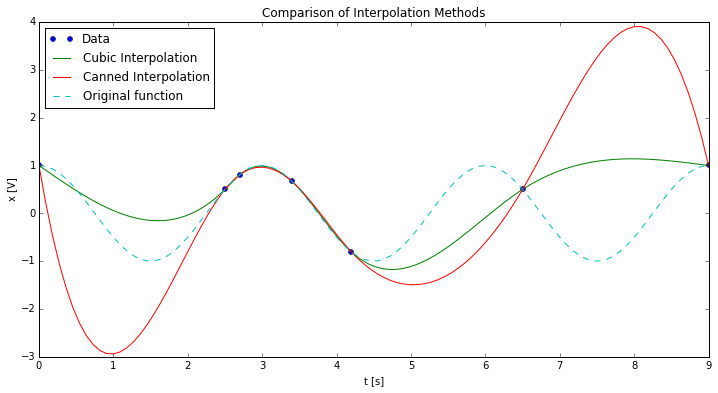

In [23]:
# Run the canned function
f = interp1d(t,x,'cubic')
tsmooth = np.linspace(t[0],t[-1],100)
xcanned = f(tsmooth)

# Run the functions
matrix,result,deltaT = createMatrix(t,x)
print 'Matrix:\n',matrix,'\n\nResult:\n',result
coeffs = solve(matrix,result)
tcubic,xcubic = interpolate(t,x,tsmooth,coeffs,deltaT)
plotEverything(t,x,tcubic,xcubic,tsmooth,xcanned)

In the comparison plot above, we can see that the original function is not properly interpolated by either method. However, when there are many data points the interpolation in both cases is correct, showing that more data produces more accurate results. We can also see that the cubic interpolation produces a function whose amplitudes are closer to those of the original function than the canned interpolation method does, at least in this case of the cosine.